### Load Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE 
from statsmodels.genmod.cov_struct import (Exchangeable, Independence, Autoregressive)
from statsmodels.genmod.families import Poisson

### The data is a study of the number of seizures being recorded on each of 236 subjects over a 16 week period, with a treatment introduced at the end of week 8. The seizure count were binned as follows: weeks 1-8, 9-10, 11-12, 13-14, 15-16. As a longitudinal data that has five measurements per subject, there's likely to be within-subject dependence.

In [2]:
dt_df = pd.read_csv('epil.csv')
dt_df.head()

,Unnamed: 0,y,trt,base,age,V4,subject,period,lbase,lage
0,1,5,placebo,11,31,0,1,1,-0.756354,0.114204
1,2,3,placebo,11,31,0,1,2,-0.756354,0.114204
2,3,3,placebo,11,31,0,1,3,-0.756354,0.114204
3,4,3,placebo,11,31,1,1,4,-0.756354,0.114204
4,5,3,placebo,11,30,0,2,1,-0.756354,0.081414


### We make some investigation to gain information about the dataset

In [3]:
dt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  236 non-null    int64  
 1   y           236 non-null    int64  
 2   trt         236 non-null    object 
 3   base        236 non-null    int64  
 4   age         236 non-null    int64  
 5   V4          236 non-null    int64  
 6   subject     236 non-null    int64  
 7   period      236 non-null    int64  
 8   lbase       236 non-null    float64
 9   lage        236 non-null    float64
dtypes: float64(2), int64(7), object(1)
memory usage: 18.6+ KB


In [4]:
#We plot graph to show the baseline seizure count in relation to the seizure count in each of the 4 follow-up periods. And then compare the relationship between the 2. We then use the square root transform to reduce skew (note also the square root transform is variance stabilizing transformation for the Poisson distribution)

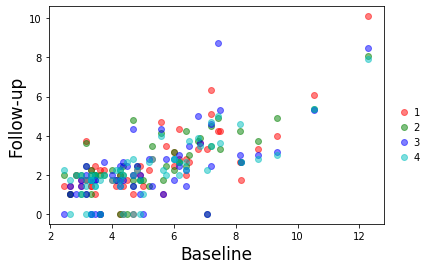

In [5]:
for period in range(1, 5):
    ii = dt_df['period'] == period
    x = np.sqrt(dt_df['base'].loc[ii])
    y = np.sqrt(dt_df['y'].loc[ii])
    plt.plot(x, y, 'o', color='rgbc'[period-1], label=str(period), alpha=0.5)
plt.xlabel('Baseline', size=17)
plt.ylabel('Follow-up', size=17)
plt.ylim(ymin=-0.5)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, 'center right', numpoints=1, handletextpad=0.0001)
leg.draw_frame(False)

### As the graph showed, the subject having more seizures in the baseline period also had more seizure in the follow-up periods.

In [7]:
fam = Poisson()
ind = Independence()
model1 = GEE.from_formula('y ~ age + trt + base', 'subject', dt_df, cov_struct=ind, family=fam)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  236
Model:                                 GEE   No. clusters:                       59
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                   4
Family:                            Poisson   Mean cluster size:                 4.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Thu, 01 Jul 2021   Scale:                           1.000
Covariance type:                    robust   Time:                         03:52:07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5730      0.361      1.589      0.112      -0.134  

### The scatterplot shown above, suggest that there is positive relationship between baseline seizure and follow-up seizure. The standard deviation of the number of baseline seizures is 26.7. Also there ios a positive relationship between age and post treatment seizure counts. The subjects in the treatment arm have fewer seizures, but there is no statistical evidence of a treatment effect.

In [15]:
result1.scale

1.0

In [ ]:
# The scale of the result1 output showed that the variance of the seizure occurrence is 1 by 1 to the mean. Next is the plot of the empirical mean/variance relationship. So we plot the mean of the repeated measures for each of subject against corresponding variance. 

C:\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0, 0.5, 'log mean')

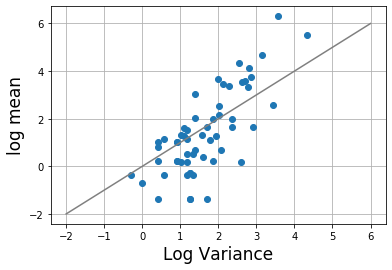

In [17]:
yg = model1.cluster_list(np.asarray(dt_df['y']))
ymn = [x.mean() for x in yg]
yva = [x.var() for x in yg]
plt.grid(True)
plt.plot(np.log(ymn), np.log(yva), 'o')
plt.plot([-2, 6], [-2, 6], '-', color='gray')
plt.xlabel('Log Variance', size=17)
plt.ylabel('log mean', size=17)

### This is an exchangeable working dependence structure to give the same parameter estimate and standard errors in this case as the independence structure.

In [11]:
fam = Poisson()
ex = Exchangeable()
model2 = GEE.from_formula('y ~ age + trt + base', 'subject', dt_df, cov_struct=ex, family=fam)
result2 = model2.fit()
print(result2.summary())
print(ex.summary())

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  236
Model:                                 GEE   No. clusters:                       59
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                   4
Family:                            Poisson   Mean cluster size:                 4.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Thu, 01 Jul 2021   Scale:                           1.000
Covariance type:                    robust   Time:                         03:52:08
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5730      0.361      1.589      0.112      -0.134  

### We now go ahead and fit the model with an autoregressive dependence structure. So starting value is going to be needed to get the estimating algorithm to converge.

In [12]:
time = np.kron(
    np.ones(
        dt_df.shape[0]//4), (
        0,1,2,3))
fam = Poisson()
ar = Autoregressive()
ar.dep_params = 0.4
model3 = GEE.from_formula("y ~ age + trt + base", "subject", dt_df, time=time, cov_struct=ar, family=fam)
result3 = model3.fit(start_params=result2.params)
print(result3.summary())
print(ar.summary())
print("scale=%.2f" % (result2.scale))

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  236
Model:                                 GEE   No. clusters:                       59
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                   4
Family:                            Poisson   Mean cluster size:                 4.0
Dependence structure:       Autoregressive   Num. iterations:                    30
Date:                     Thu, 01 Jul 2021   Scale:                           1.000
Covariance type:                    robust   Time:                         03:52:08
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4123      0.422      0.977      0.329      -0.415  

### In an attempt to probe dependence structure a bit more, we plot a graph of empirical correlation between residuals of the time spacing. So the plot suggest that the dependence decreases with time, so the autoregressive structure seems to be more suitable.

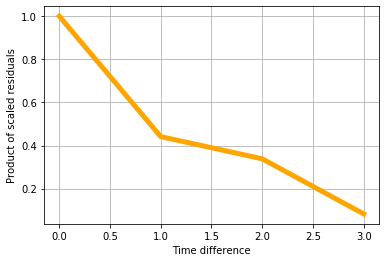

In [13]:
fig = result1.plot_isotropic_dependence()
plt.grid(True)

### Now let's look at how one of the regressive parameters changes as we hold the autocorrelation parameter fixed at various values. The broken vertical line shows the estimate autocorrelation parameter.

Text(0, 0.5, 'Age effect')

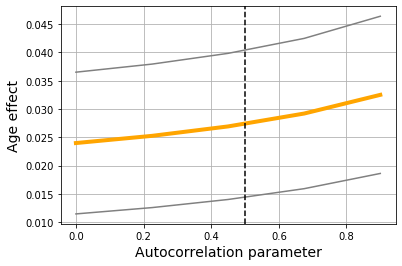

In [14]:
rslts = result3.params_sensitivity(0., 0.9, 5)
dp = [x.cov_struct.dep_params for x in rslts]
age_params = np.asarray([x.params[2] for x in rslts])
age_se = np.asarray([x.bse[2] for x in rslts])
plt.grid(True)
plt.plot(dp, age_params, '-', color='orange', lw=4)
plt.plot(dp, age_params + age_se, '-', color='grey')
plt.plot(dp, age_params - age_se, '-', color='grey')
plt.axvline(result3.cov_struct.dep_params, ls='--', color='black')
plt.xlabel("Autocorrelation parameter", size=14)
plt.ylabel("Age effect", size=14)